### Lab 4 Overview
#### First Half
- Doing basic statistical models with Python
- R to Python equivalents 

#### Second Half
- *Questions?*
- *Industry techniques and basic procedures?*

### Statistical Learning in Python
- Regression
- General Linear Models (GLM, more from MAST30027...)
- LASSO and Ridge Regression 
- Non-regression based methods

We will be using `"100k_yellow_2015_05.csv"` which can be obtained from Canvas.  
This dataset is a 100k sample from (https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv) 


```python
import urllib

outputDir = "../Data/Lab4/100k_yellow_2015_05.csv"
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
urllib.request.urlretrieve(url, outputDir)
print(f"Done downloading {fname} to ./{outputDir}")
```

___________________

In [1]:
# this is the equivalent package lm or glm
from statsmodels.formula.api import *

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# read in the data
import pandas as pd
df = pd.read_csv("../Data/Lab4/100k_yellow_2015_05.csv")

In [2]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

(From the lab): As an example, let's try to predict `total_amount` using `fare_amount, tip_amount, toll_amount, trip_distance, VendorID` as predictors.

Some things to take note:
- `tip_amount` is only valid for `payment_type == 1` (card)
- `VendorID` is categorical, with only two possible values (`1` or `2`) so we should make it boolean

In [3]:
# filter dataframe
COL_FILTER = ['total_amount', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']
df_filtered = df.loc[df['payment_type'] == 1, COL_FILTER].reset_index(drop=True)
df_filtered['VendorID'] = df_filtered['VendorID'] == 1

df_filtered.tail()

total_amount  fare_amount  tip_amount  tolls_amount  trip_distance  \
61887         12.25          8.0        2.45           0.0           1.70   
61888          8.16          5.0        1.36           0.0           0.89   
61889          7.55          4.5        1.25           0.0           0.50   
61890         11.80          9.0        2.00           0.0           1.80   
61891         11.00          8.0        2.20           0.0           1.90   

       VendorID  
61887     False  
61888     False  
61889      True  
61890      True  
61891      True

(From the lab): We are looking for linear relationships between our chosen response `total_amount`.   
(Me): Now I'm not sure what kind of life you've lived, but I'm fairly certain that we can infer that `total_amount` will have a positive linear relationship with `fare_amount`. Let's see a quick plot...

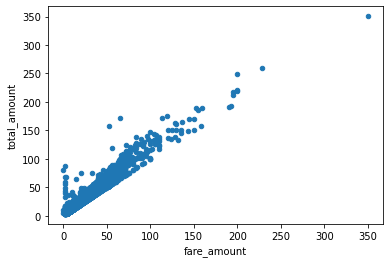

In [4]:
df_filtered[['total_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='total_amount')
plt.show()

Well, obviously this looks like an overall positive linear relationship.
- How might we statistically test this?

-------

In R, we would do something like this for (Ordinary) Least Squares:
```R
>>> fit <- lm(total_amount~fare_amount + tip_amount + tolls_amount + trip_distance + VendorID ,data=dat_fit)
>>> summary(fit)
```
```
Call:
lm(formula = total_amount ~ fare_amount + tip_amount + tolls_amount +
trip_distance + VendorID, data = dat_fit)

Residuals:
Min     1Q      Median  3Q     Max
-1.4727 -0.3295 -0.1528 0.1747 1.7975

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    1.162154   0.002986 389.194  <2e-16 ***
fare_amount    0.993388   0.000315 3153.943 <2e-16 ***
tip_amount     1.006511   0.000826 1218.553 <2e-16 ***
tolls_amount   0.979325   0.001285 762.428  <2e-16 ***
trip_distance  0.011742   0.000963 12.194   <2e-16 ***
VendorIDTRUE  -0.003125   0.002914 -1.073    0.283
---
Signif. codes:
0 ^a˘A¨Y***^a˘A´Z 0.001 ^a˘A¨Y**^a˘A´Z 0.01 ^a˘A¨Y*^a˘A´Z 0.05 ^a˘A¨Y.^a˘A´Z 0.1 ^a˘A¨Y ^a˘A´Z 1

Residual standard error: 0.362 on 61886 degrees of freedom
Multiple R-squared: 0.9994,          Adjusted R-squared: 0.9994
F-statistic: 1.953e+07 on 5 and 61886 DF, p-value: < 2.2e-16
```

Well, whatever you can do in R can also done in Python (to an extent).  
Documentation Source: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html?highlight=ols

In [5]:
fit = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance + VendorID",
         data=df_filtered).fit()

In [6]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.953e+07
Date:                Sat, 29 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:49:57   Log-Likelihood:                -24933.
No. Observations:               61892   AIC:                         4.988e+04
Df Residuals:                   61886   BIC:                         4.993e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1622      0.003  

- The table structure is a bit different, though it is identical in value with R's output.  
- The coefficient table is the same, but now includes a 95% CI for the beta coefficients.



___________________

Questions:
- Is this model good?
    - The $R^2$ value is 0.999 which is insanely large. As a rule of thumb, large $R^2$ values indicate a good fit. 
    - *Perhaps too good of a fit...*
    - AIC itself isn't important, however, if we compare it to another model (let's say an alternative model with different features chosen)...
    - If we have a hypothesis for a null model ($\beta=0$) vs our fitted model ($\beta\neq0$), then we can look at the `F-statistc = 1.953e+07`. The corresponding p-value of  this F statistic is `0.00`, which is less than $\alpha=0.05$, so we can conclude that our fitted model is better than a null model. In other words, we reject the null hypothesis and conclude that we believe the intercept parameters to be non-zero.
    
    
- How might we improve this model?
    - If we look at the parameters, we may wish to exclude `VendorID[T.True]` as it is not significant with p-value `0.283 > 0.05`. Perhaps we should drop this attribute and fit another model without it.
    - Additionally, we can do some feature engineering (run a decision tree and look at the splits)

In [10]:
fitter = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance",
         data=df_filtered).fit()
print(fitter.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.441e+07
Date:                Sat, 29 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:50:23   Log-Likelihood:                -24933.
No. Observations:               61892   AIC:                         4.988e+04
Df Residuals:                   61887   BIC:                         4.992e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1606      0.003    440.908

___________________

- Now that we have to values of AIC to compare with, which one is better...?
    - Well, we see a small decrease in AIC and a large decrease in BIC. Hence, we can say that the model without `VendorID` is better.

In [12]:
[fit.aic, fitter.aic], [fit.bic, fitter.bic]

([49877.70777173292, 49876.858381244325],
 [49931.90664899058, 49922.024112292376])

### LASSO 
- One of many ways to avoid overfitting 
- Bit of a work around to install with Python in general.
- Refer to the next section for an installation guide on Windows / Installing fortran compiler for Linux
- **or you can use R for this**

Quick overview:
- LASSO may cause coefficients to be set to 0
- To prevent this, we need to standardize the predictor X matrixs (aka your sample points) to have $\mu=0, \sigma^2=1$

Pros:
- Computationally cheaper than stepwise and (obviously) best subset
- Works well for high dimensions

Cons:
- Results are sensitive to choice of parameters (notably $\lambda$)
- Doesn't work as well when all the features are significant or coefficient values are large
- Biased estimator (only OLS is unbiased)

Revise in your own time if you've forgotten:
- Lecture 4 (variable selection)
- LSM topic 5 (`ch05_handout`) slide 141/141
![lasso](./cloud/lasso.PNG)

In [13]:
yCOLS = ['total_amount']
xCOLS = ['fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
from scipy.stats import zscore
df_standard = df_filtered[xCOLS].astype(float).apply(zscore)

In [33]:
# format output to 2 decimal places
pd.options.display.float_format = '{:,.4f}'.format
df_standard.describe().loc[['mean','std']]

fare_amount  tip_amount  tolls_amount  trip_distance  VendorID
mean       0.0000      0.0000       -0.0000        -0.0000   -0.0000
std        1.0000      1.0000        1.0000         1.0000    1.0000

As you can see, `df_standard` has  $\mu=0, \sigma=1(=\sigma^2)$  

Note that the code below for `glmnet` will most likely cause issues (yep, **another** workaround to do). R is natively built for this, but I have been more accustomed to using `glmnet` with Python...

In [30]:
# now we can fit our model
from glmnet import ElasticNet

lasso_fit = ElasticNet()
lasso_fit.fit(df_standard.values, df_filtered[yCOLS].values)

ElasticNet()

Now, we want to look at the shrinking parameter $\lambda$.  

In [31]:
# this can be accessed using the .lambda_best_ method after fitting!
print(f'Best lambda value for LASSO: {lasso_fit.lambda_best_[0]}')

Best lambda value for LASSO: 0.23665078615126328


What about our coefficients?

In [38]:
# you can access the attributes to get your coefficients
# refer to https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py for full details
pd.DataFrame(index = ['Intercept'] + xCOLS, 
             data= [lasso_fit.intercept_] + list(lasso_fit.coef_), 
             columns = ['Coefficient'])

Coefficient
Intercept          18.0736
fare_amount        11.2272
tip_amount          2.5958
tolls_amount        1.3317
trip_distance       0.0000
VendorID            0.0000

As you can see, `trip_distance` and `VendorID` have *shrunk* to 0. You can use `lasso_fit.predict(x)` to the predict a new set of observations by passing through the `x` matrix

___________________

### Fitting a GLM
- Well, this is exactly what you *should* be learning in MAS (MAST30027) right now

(From the lab): The `passenger_count` attribute is discrete and non-negative. If we were to predict it, a linear model will not be sufficient. 
- (From the lab): We know that a poisson distribution takes in non-negative integer values, so we can use the Poisson family of GLMs to model this. 
- (From the lab): We will use `total_amount, trip_distance, VendorID` as our regressors.

In [10]:
from statsmodels.api import families

# convert VendorID to categorical
df['VendorID'] = df['VendorID'] == 1

fit = glm(formula="passenger_count ~ total_amount + trip_distance + VendorID",
         data=df, family=families.Poisson()).fit()

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        passenger_count   No. Observations:                99999
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4936e+05
Date:                Tue, 25 Aug 2020   Deviance:                       69274.
Time:                        11:49:27   Pearson chi2:                 8.50e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7194      0.004  

- We can see that `total_amount` is insignificant (`p-val=0.124>0.05`)
- Conclude that the total fare amount does not really affect the number of passengers in a trip

-------------

### Discussion
- Is using regression on X attribute / specific dataset even a good choice...?
    - The answer is yes, it is a good choice *to try*
    - BUT also try other methods...
    
    
- What are the pros and cons of stepwise regression?
    - Forward Selection (start from nothing and end until significant)
    - Backward Elimination (start with everything and end until no more can be removed)
    - Not always the best results...
    
    
- What is best subset regression and the pros and cons of it?
    - A brute-force like method of fitting *all posssible regressuibs* or *all possible models*
    - Unlike stepwise, this method fits all possible models based on the variables specified, so you will get the best model possible
    ![test](https://i.kym-cdn.com/photos/images/newsfeed/001/718/138/147.jpg)
    
    
    
- What is an assumption we make when we fit linear regression models?
    - Well, the data has to be linearly seperable. 
    - Does this also apply to other models too...? (Recall SVM and kernel function which we can use)
    - Perhaps another model might suit the dataset... (Trees, Neural Networks, Clustering, etc...)
    
    
- If you were to use a decision tree, how would you compare between two different fits? 
    - Look at Gini Impurity (probability of an incorrectly classified instance)
    

- How about baselines or other predictive machine learning models?
    - Precision, Recall, Classification Accuracy...

-----------

### Feature Engineering?
- We want to see if the the profitability of zones remains consistent with respect to hour of day, day of week and pickup location. The distribution of profitable zones should be similar across all years.
- How is a zone profitable? Frequency of trips? Duration of trips? Best "earners"? etc...
- You could create such a feature and scale it accordingly...
- Perhaps the expected dollar per minute + possible tolls scaled by the expected frequency of trips...

- Just remember that trip frequency $\approx$ taxi demand in a zone (you don't know the number of taxis in a zone at the time)
- Variable rate fares: *"50 cents per 1/5 mile when travelling above 12mph OR 50 cents per 60 seconds in slow traffic or when the vehicle is stopped."*
- Profit rates might assume crude approximations degrading into linear distance / constant velocity / etc

-----------

### Installation Guide for glmnet Windows
- Documentation for Python `glmnet`: https://github.com/civisanalytics/python-glmnet

#### Method 0 (Preffered):
- Face reality and accept that Windows breaks a lot of things
- After accepting reality, uninstall anaconda and any python environment you have installed
- Complete all of with Method 1
- Launch Jupyter with `jupyter notebook` and copy paste the link into your browser!

#### Method 1:
- Install WSL (refer to lab1's link)
- Run these commands:
    - `sudo apt-get install python3`
    - `sudo apt-get install python3-pip`
- Done. You now have `python3` on linux working!
- Install packages:
    - `pip3 install pandas matplotlib seaborn numpy notebook geopandas folium bokeh` (and so on...)
- Install `glmnet`:
    1. `sudo add-apt-repository ppa:jonathonf/gcc-7.1`
    2. `sudo apt-get update`
    3. `sudo apt-get install gcc-7 g++-7`
    4. `sudo apt-get install gfortran-7`
    5. `sudo apt-get install gfortran`
    6. `pip3 install glmnet`
- Now you can use Jupyter Notebooks' bash magic to run the required parts
- =======================================================================
- If error, try https://stackoverflow.com/questions/46516394/how-to-install-libgfortran-so-4-on-ubuntu-16-06
- Else if the above step doesn't work, move onto Method 2

#### Method 2:
- idk you could try this link: https://stackoverflow.com/a/56444043

#### Method 3 (Easiest):
- Just use `R` if you *really* want to do LASSO